In [9]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array, hex_array
from hera_filters import dspec
from jax import numpy as jnp
from hera_cal import abscal, redcal, datacontainer, apply_cal
from stefcal import calibration
from copy import deepcopy
import jax
from hera_sim import vis, utils
from scipy import stats
jax.config.update("jax_enable_x64", True)
%matplotlib notebook
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [34]:
nfreqs = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
#antpos = hex_array(6, split_core=True, outriggers=0)
antpos = linear_array(10)
reds = redcal.get_reds(antpos)

_gains, model_vis, data_vis = vis.sim_red_data(reds, shape=(2, nfreqs))
data_vis = datacontainer.DataContainer(data_vis)
model_vis = datacontainer.DataContainer({bl: model_vis[group[0]] for group in reds for bl in group})

noise_scale = 1e-3
for k in data_vis:
    data_vis[k] += (
        np.random.normal(0, noise_scale, size=(1, nfreqs)) + 
        1j * np.random.normal(0, noise_scale, size=(1, nfreqs))
    )
    
flags = datacontainer.DataContainer({k: np.zeros(data_vis[k].shape, dtype=bool) for k in data_vis})

In [36]:
%%timeit
gains_stef, niter, conv_crit = calibration.sky_calibration(
    data_vis, model_vis, flags, maxiter=1000, tol=1e-10, stepsize=0.5
)
data_stef = deepcopy(data_vis)
apply_cal.calibrate_in_place(data_stef, gains_stef)

49.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
len(gains_stef)

85

In [17]:
%%timeit
# Amplitude fit
amp_fit = abscal.amp_logcal(model_vis, data_vis, verbose=False)    
phs_fit = abscal.phs_logcal(model_vis, data_vis, verbose=False)

data_abscal = deepcopy(data_vis)
data_abscal = datacontainer.DataContainer(data_abscal)

gains = {}
for k in antpos:
    gains[(k, 'Jnn')] = np.exp(amp_fit[f'eta_{k}_Jnn'] + 1j * phs_fit[f'phi_{k}_Jnn'])
    
apply_cal.calibrate_in_place(data_abscal, gains)

98.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


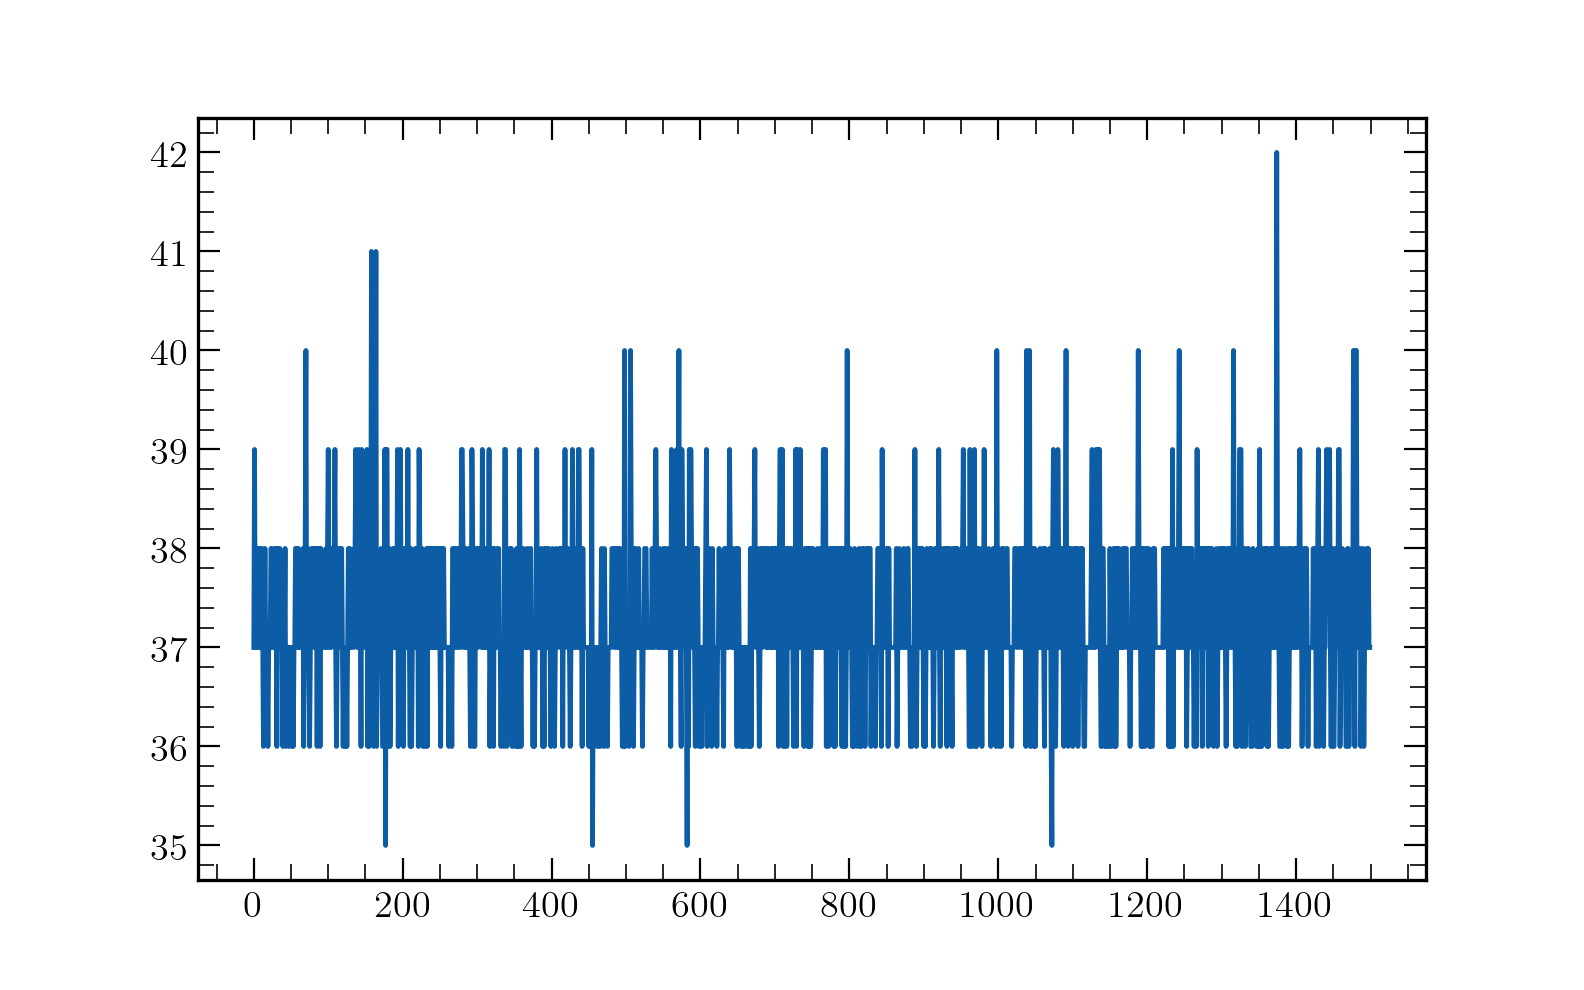

In [6]:
plt.figure()
plt.plot(niter['nn'].T)

In [7]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


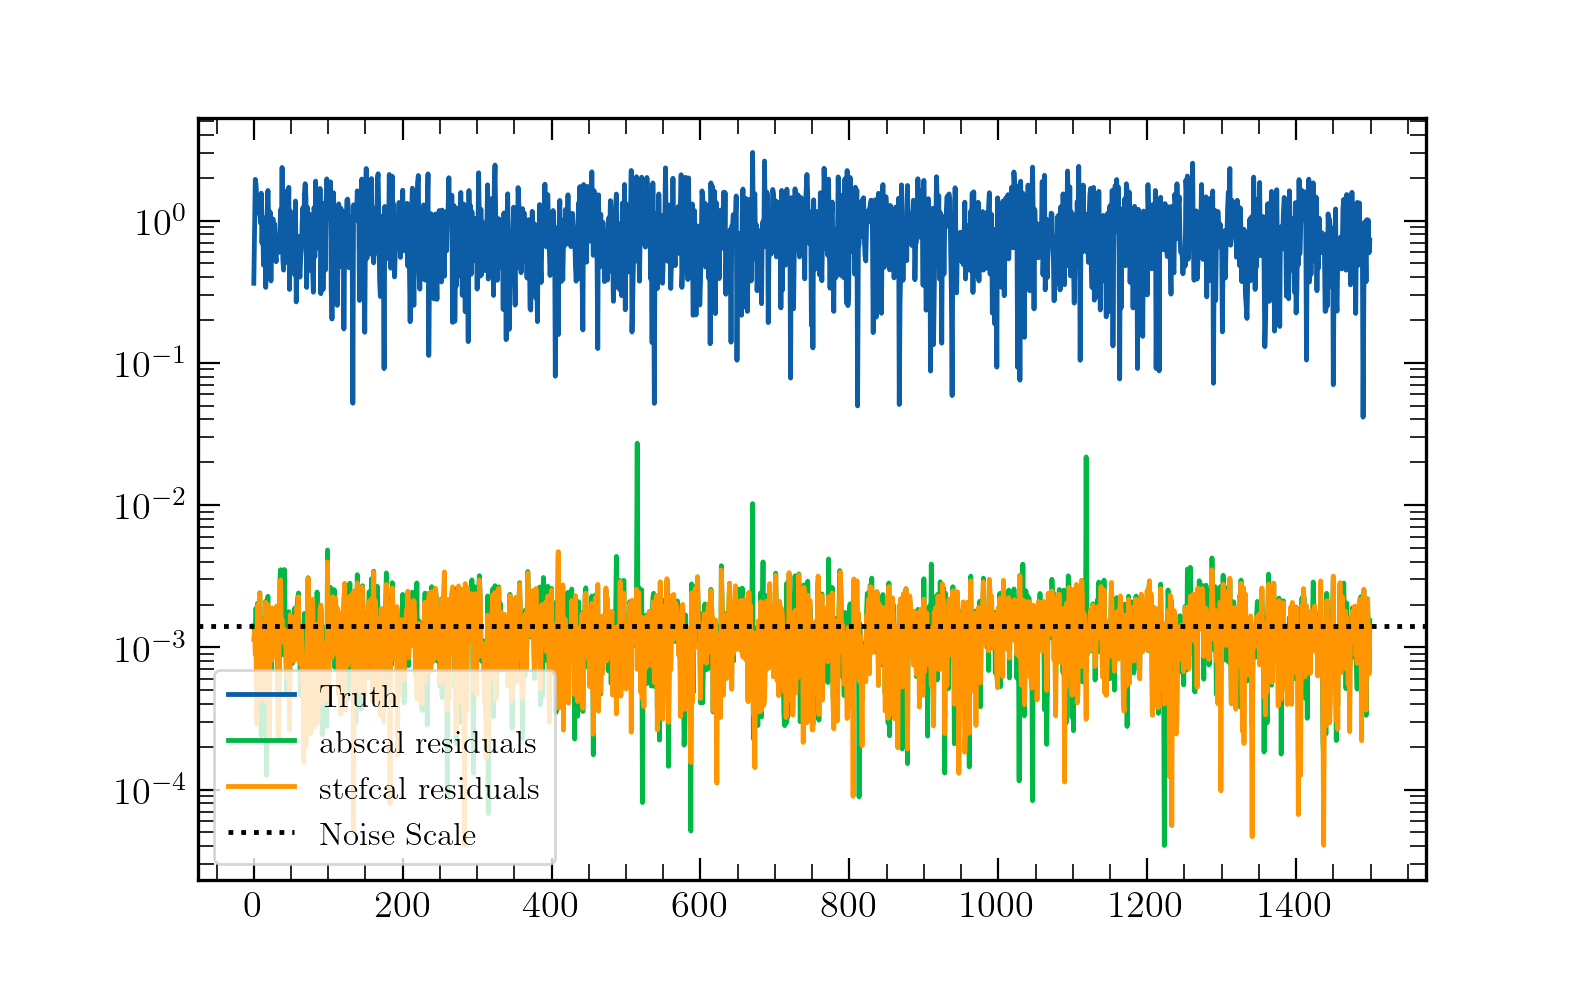

In [8]:
plt.figure()
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0]), label='Truth')
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0] - data_abscal[0, 3, 'nn'][0]), ls='-', label='abscal residuals')
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0] - data_stef[0, 3, 'nn'][0]), ls='-', label='stefcal residuals')
plt.axhline(noise_scale * np.sqrt(2), color='k', ls=':', label='Noise Scale')
plt.legend(fontsize=12, loc='lower left')
plt.show()

## Abscal Approach

In [113]:
ants = list(antpos.keys())

In [6]:
%%time
#vis_dict_copy = deepcopy(data_vis)
#vis_dict_copy = datacontainer.DataContainer(vis_dict_copy)

# Amplitude fit
amp_fit = abscal.amp_logcal(model_vis, data_vis, verbose=False)    
phs_fit = abscal.phs_logcal(model_vis, data_vis, verbose=False)

#gains = {}
#for k in antpos:
#    gains[(k, 'Jnn')] = np.exp(amp_fit[f'eta_{k}_Jnn'] + 1j * phs_fit[f'phi_{k}_Jnn'])
    
#apply_cal.calibrate_in_place(vis_dict_copy, gains)

CPU times: user 52.8 s, sys: 10.6 s, total: 1min 3s
Wall time: 33.4 s


<IPython.core.display.Javascript object>


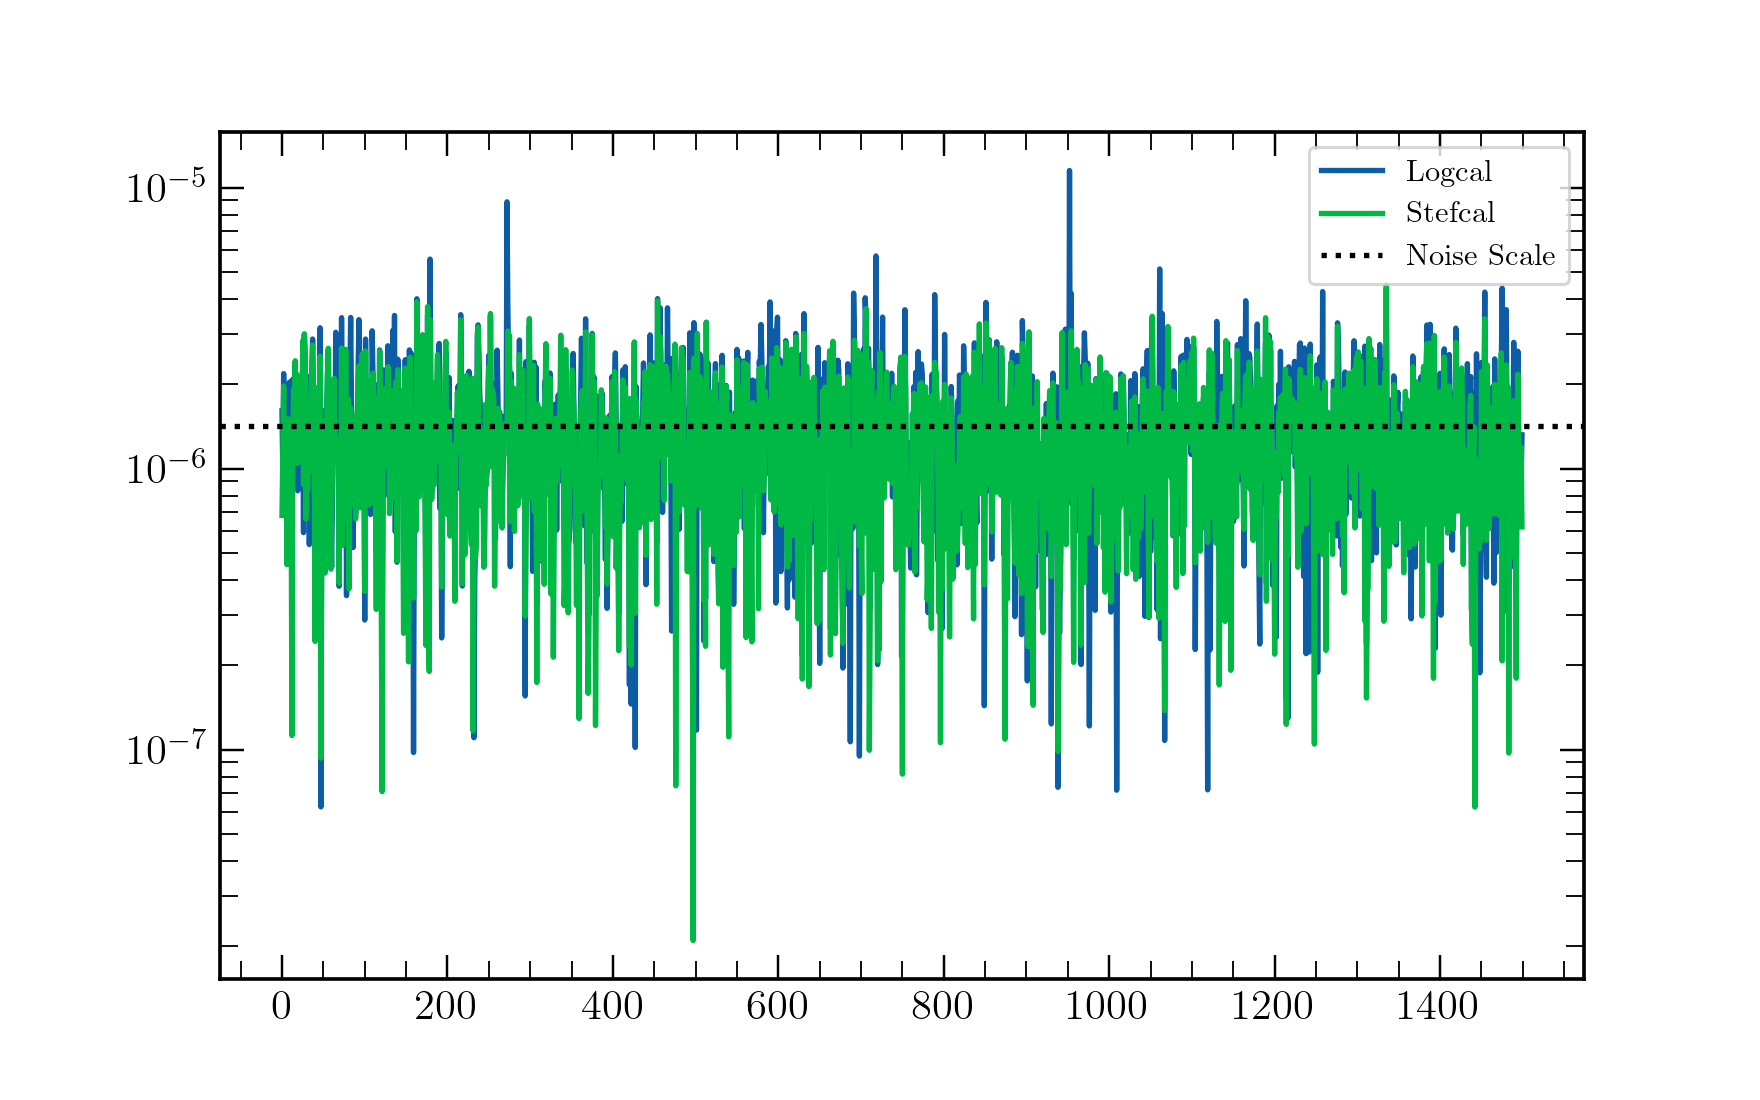

In [115]:
plt.figure()
plt.semilogy(np.abs(vis_dict_copy[(0, 2, 'nn')][0] - model_vis[(0, 2, 'nn')][0]), ls='-', label='Logcal')
plt.semilogy(np.abs(data_vis_copy[0, 2, 'nn'][0] - model_vis[0, 2, 'nn'][0]), ls='-', label='Stefcal')
plt.axhline(noise_scale * np.sqrt(2), color='k', ls=':', label='Noise Scale')
plt.legend()
plt.show()

In [116]:
len(antpos)

115